In [1]:
!which python
!which pip
# !pip show pandas

/Users/nishanholla/miniconda3/envs/myenv/bin/python
/Users/nishanholla/miniconda3/envs/myenv/bin/pip


In [1]:
!pip install chardet

In [1]:
import chardet
import pandas as pd

df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df.head()

ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "/Users/nishanholla/miniconda3/envs/myenv/bin/python"
  * The NumPy version is: "1.24.4"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Users/nishanholla/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/libcblas.3.dylib
  Referenced from: <F6CB08DE-7D5B-3BBE-A58E-4E0EAD3D0FC7> /Users/nishanholla/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so
  Reason: tried: '/Users/nishanholla/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/../../../../libcblas.3.dylib' (no such file), '/Users/nishanholla/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/../../../../libcblas.3.dylib' (no such file), '/Users/nishanholla/miniconda3/envs/myenv/bin/../lib/libcblas.3.dylib' (no such file), '/Users/nishanholla/miniconda3/envs/myenv/bin/../lib/libcblas.3.dylib' (no such file), '/usr/local/lib/libcblas.3.dylib' (no such file), '/usr/lib/libcblas.3.dylib' (no such file, not in dyld cache)


In [21]:
len(df)

525461

In [23]:
type(df)

pandas.core.frame.DataFrame

In [44]:
df_clean = df.dropna()
df_clean = df_clean.drop_duplicates()
df = df_clean

In [45]:
len(df_clean)

410763

In [46]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [47]:
numeric_cols = df.select_dtypes(include=['number']).columns

# Apply IQR method to remove outliers
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
df_filtered = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display the cleaned DataFrame
print(df_filtered.shape) 

(349025, 8)


In [53]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

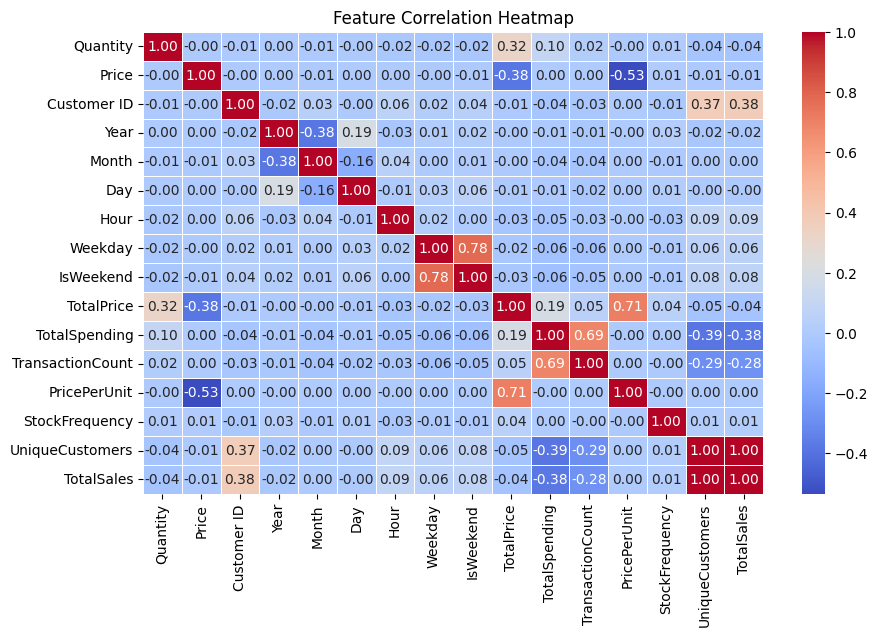

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
num_cols = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = num_cols.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [62]:
# Identify highly correlated features
threshold = 0.8
high_corr = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

print("Highly Correlated Features to Remove:", high_corr)

# Drop highly correlated features
df.drop(columns=high_corr, inplace=True)

Highly Correlated Features to Remove: {'TotalSales'}


In [55]:
df['Country'].value_counts()

Country
United Kingdom          372705
EIRE                      8705
Germany                   8120
France                    5692
Netherlands               2768
Spain                     1271
Switzerland               1187
Belgium                   1053
Portugal                  1023
Channel Islands            906
Sweden                     882
Italy                      729
Australia                  654
Cyprus                     546
Austria                    537
Greece                     517
Denmark                    428
Norway                     369
Finland                    354
United Arab Emirates       318
Unspecified                280
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
Canada                      77
Thailand                    76
Israel                      74
Iceland                     71
RSA                         65


In [56]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Day"] = df["InvoiceDate"].dt.day
df["Hour"] = df["InvoiceDate"].dt.hour
df["Weekday"] = df["InvoiceDate"].dt.weekday  # 0 = Monday, 6 = Sunday
df["IsWeekend"] = (df["Weekday"] >= 5).astype(int)

In [57]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
customer_spending = df.groupby("Customer ID")["TotalPrice"].sum().reset_index()
customer_spending.rename(columns={"TotalPrice": "TotalSpending"}, inplace=True)

customer_freq = df.groupby("Customer ID")["Invoice"].nunique().reset_index()
customer_freq.rename(columns={"Invoice": "TransactionCount"}, inplace=True)

df = df.merge(customer_spending, on="Customer ID", how="left")
df = df.merge(customer_freq, on="Customer ID", how="left")

In [58]:
df["PricePerUnit"] = df["Price"] / df["Quantity"].replace(0, 1)  # Avoid division by zero
stock_popularity = df["StockCode"].value_counts().reset_index()
stock_popularity.columns = ["StockCode", "StockFrequency"]
df = df.merge(stock_popularity, on="StockCode", how="left")

In [59]:
country_customers = df.groupby("Country")["Customer ID"].nunique().reset_index()
country_customers.rename(columns={"Customer ID": "UniqueCustomers"}, inplace=True)

country_sales = df.groupby("Country")["TotalPrice"].sum().reset_index()
country_sales.rename(columns={"TotalPrice": "TotalSales"}, inplace=True)

df = df.merge(country_customers, on="Country", how="left")
df = df.merge(country_sales, on="Country", how="left")